Github : https://github.com/Tiziri-k/Sentiment-Analysis

# Import librairies

In [7]:
!pip install tweepy


In [8]:
!pip install tensorflow
import numpy as np
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import nltk
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.models import Sequential
import tweepy as tw #for accessing Twitter API

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
nltk.download('stopwords')
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import re
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Get the twitter data

In [9]:
# consumer_key = "*********************"
# consumer_secret = "**************************"
# access_token = "**************************"
# access_token_secret = "*************************"


# auth = tw.OAuth1UserHandler(
#     consumer_key, consumer_secret,
#     access_token, access_token_secret
# )

# api = tw.API(auth, wait_on_rate_limit=True)

# search_query = "'ref''world cup'-filter:retweets AND -filter:replies AND -filter:links"
# no_of_tweets = 100

# try:
#     tweets = api.search_tweets(q=search_query, lang="en", count=no_of_tweets, tweet_mode ='extended')
#     attributes_container = [[tweet.user.name, tweet.created_at, tweet.favorite_count, tweet.source, tweet.full_text] for tweet in tweets]
#     columns = ["User", "Date Created", "Number of Likes", "Source of Tweet", "Tweet"]
#     tweets_df = pd.DataFrame(attributes_container, columns=columns)
# except BaseException as e:
#     print('Status Failed On,',str(e))

# from google.colab import files
# tweets_df.to_csv('Twitter_Data.csv')
# files.download('Twitter_Data.csv')

# Load Data

                                 We decided to concatenate 3 large dataset that we found on the internet which are :
                              1- Reddit_Data.csv (-1: negative , 0 neutral , 1: positve)
                              2- Twitter_Data  (-1: negative , 0 neutral , 1: positve)
                              3- Apple-Twitter-Sentiment-DFE.csv (1: negative , 3 neutral , 5: positive)

In [10]:
import zipfile
import pandas as pd


with zipfile.ZipFile("/content/nlp_data.zip", "r") as zip_ref:
    zip_ref.extractall("data")



dataset1 = pd.read_csv("data/nlp_data/Apple-Twitter-Sentiment-DFE.csv", encoding="ISO-8859-1")
dataset2 = pd.read_csv("data/nlp_data/Reddit_Data.csv")
dataset3 = pd.read_csv("data/nlp_data/Twitter_Data.csv",sep=',')


In [11]:
dataset1.sentiment.unique(),dataset2.category.unique(),dataset3.category.unique()

(array(['3', '5', '1', 'not_relevant'], dtype=object),
 array([ 1, -1,  0]),
 array([-1.,  0.,  1., nan]))

In [12]:
# Select only the 'text' and 'sentiment' columns
dataset1 = dataset1[['text', 'sentiment']]

# Filter out rows with 'not_relevant' sentiment since its not about the appel product
dataset1 = dataset1[dataset1.sentiment != 'not_relevant']

# Map sentiment values to a specific format to match other 2 datasets
dataset1['sentiment'] = dataset1['sentiment'].map({'1': -1.0, '3': 0.0, '5': 1.0})

dataset1

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,0.0
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,0.0
2,My cat only chews @apple cords. Such an #Apple...,0.0
3,I agree with @jimcramer that the #IndividualIn...,0.0
4,Nobody expects the Spanish Inquisition #AAPL,0.0
...,...,...
3881,(Via FC) Apple Is Warming Up To Social Media -...,0.0
3882,RT @MMLXIV: there is no avocado emoji may I as...,0.0
3883,@marcbulandr I could not agree more. Between @...,1.0
3884,My iPhone 5's photos are no longer downloading...,-1.0


***Concatenate the 3 datasets***

In [13]:
dataset2  = dataset2.rename(columns={'clean_comment': 'clean_text', 'category':'category'})
dataset1  = dataset2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
data = pd.concat([ dataset2, dataset3], ignore_index=True)
data.head(3)

,clean_text,category
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0


In [14]:
print('Data shape : ',data.shape)
print('Nan values :\n',data.isnull().sum())

Data shape :  (200229, 2)
Nan values :
 clean_text    104
category        7
dtype: int64


***Drop NaN values***

In [15]:
data.dropna(axis=0, inplace=True)
data['category'] = data['category'].astype(int)
data

,clean_text,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
200224,why these 456 crores paid neerav modi not reco...,-1
200225,dear rss terrorist payal gawar what about modi...,-1
200226,did you cover her interaction forum where she ...,0
200227,there big project came into india modi dream p...,0


In [16]:
print('Data shape : ',data.shape)
print('Nan values :\n',data.isnull().sum())

Data shape :  (200118, 2)
Nan values :
 clean_text    0
category      0
dtype: int64


# EDA

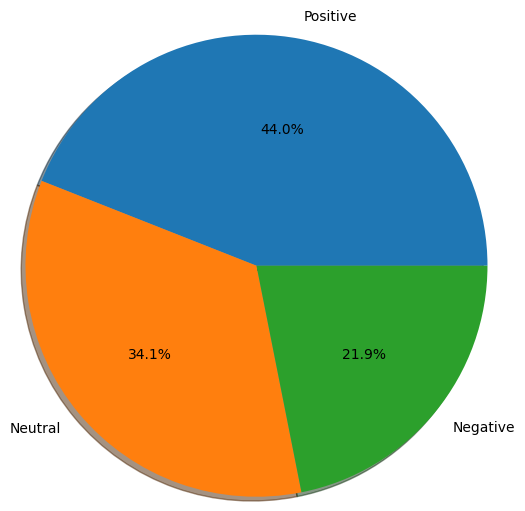

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

label = data['category'].map({-1 : 'Negative', 0 : 'Neutral', 1 : 'Positive'}).value_counts().index
label_count = data['category'].value_counts().values
plt.pie(x=label_count, labels=label, autopct='%1.1f%%', shadow=True, radius=1.5)

plt.show()


In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def wordcount_gen(data, category):
    combined_tweets = " ".join([tweet for tweet in data[data.category==category]['clean_text']])

    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords=STOPWORDS)

    labels = {1: 'Positive', 0: 'Neutral', -1: 'Negative'}

    plt.figure(figsize=(8,8))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(labels[category]), fontsize=20)
    plt.axis('off')
    plt.show()



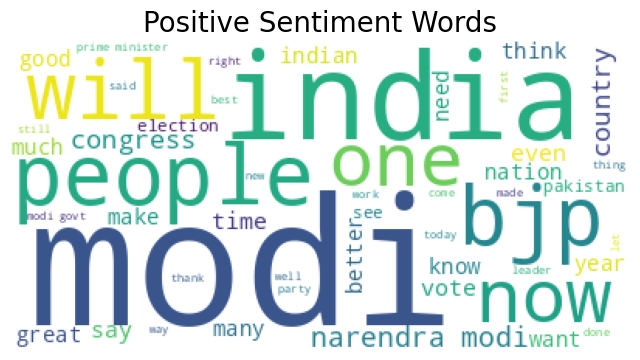

In [19]:
wordcount_gen(data, 1)

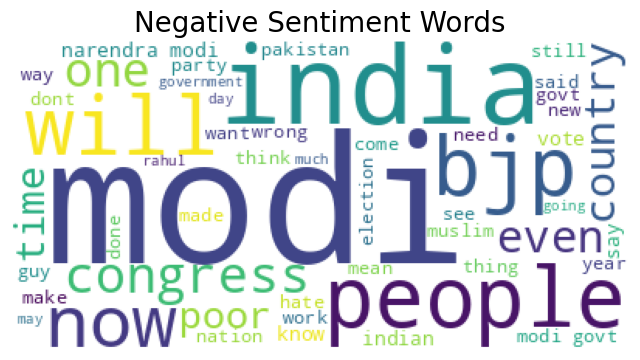

In [20]:
wordcount_gen(data, -1)

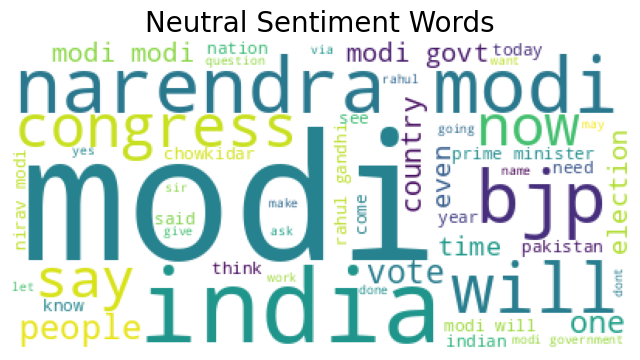

In [21]:
wordcount_gen(data, 0)

# Data Preprocessing

***Clean Data***

In [22]:
stw= stopwords.words("english")

In [23]:

def clean_text_fun(txt):

    # Remove emails, dates, and usernames
    txt = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', txt)
    txt = re.sub(r'\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{1,2}[/-]\d{2,4})\b', '', txt)
    txt = re.sub(r'@[A-Za-z0-9]+', '', txt)

    # Remove emojis
    txt = re.sub(r':\)|:-\)|;\)|:-\(|:-\(|:-\)|:-D|:D|:-P|:P|:-O|:O|:-/|:/|:-\|', '', txt)

    # Remove links
    txt = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', txt)

    # Keep only alphabetic text
    txt = re.sub(r"[^a-zA-Z ]", " ", txt)

    # Lowercase the text
    txt = txt.lower()

    # Normalize words like 've, 'll, n’t
    txt = re.sub(r"'ve", " have", txt)
    txt = re.sub(r"'ll", " will", txt)
    txt = re.sub(r"n’t", " not", txt)

    # Tokenize the text
    words = txt.split()

    # Remove stopwords and stem the words
    processed_words = [PorterStemmer().stem(w) for w in words if w not in stw]

    # Join the processed words back into a string
    txt = " ".join(processed_words)

    return txt

data['clean_text'] =   data['clean_text'].apply(clean_text_fun)

***Tokenization and Padding***

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = None
max_len = 100

def tokenize_pad_sequences(text):
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

X, tokenizer = tokenize_pad_sequences(data['clean_text'])


***Word2Vec Model Training***

In [25]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(sentences=X.tolist(), vector_size=100, window=5, min_count=1, workers=4)

def word2vec_embedding(text_data, model):
    embeddings = []
    for sentence in text_data:
        embedding = []
        for word_index in sentence:
            word = tokenizer.index_word.get(word_index, '')
            if word in model.wv:
                embedding.append(model.wv[word])
        embeddings.append(embedding)
    return embeddings

X_w2v = word2vec_embedding(X, word2vec_model)


***Split the data***

In [26]:
y = data['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

***Convert target labels to one-hot encoded vectors***

In [27]:
from keras.utils import to_categorical
num_classes = 3
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# LBSTM

In [28]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense,Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint



model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [29]:
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
1001/1001 [==============================] - 362s 356ms/step - loss: 0.5424 - accuracy: 0.8021 - val_loss: 0.4023 - val_accuracy: 0.8600
Epoch 2/20
1001/1001 [==============================] - 346s 345ms/step - loss: 0.3734 - accuracy: 0.8782 - val_loss: 0.4103 - val_accuracy: 0.8552
Epoch 3/20
1001/1001 [==============================] - 364s 363ms/step - loss: 0.2817 - accuracy: 0.9103 - val_loss: 0.4493 - val_accuracy: 0.8471
Epoch 4/20
1001/1001 [==============================] - 352s 352ms/step - loss: 0.2106 - accuracy: 0.9347 - val_loss: 0.5413 - val_accuracy: 0.8345


In [30]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


1251/1251 [==============================] - 17s 14ms/step - loss: 0.4089 - accuracy: 0.8584
Test Loss: 0.40889352560043335
Test Accuracy: 0.8583599925041199


***Evaluate the train result***

1251/1251 [==============================] - 17s 13ms/step


Text(70.72222222222221, 0.5, 'Predicted label')

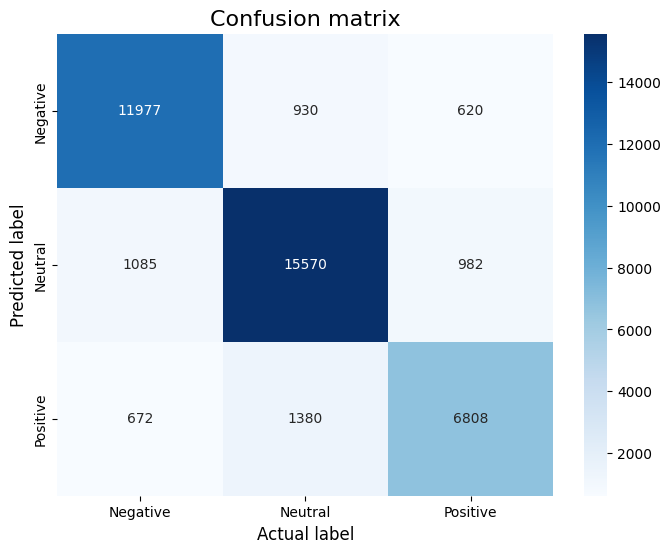

In [31]:
from sklearn.metrics import confusion_matrix


sentiment_classes = ['Negative', 'Neutral', 'Positive']
y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(np.array(y_test_encoded),axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)



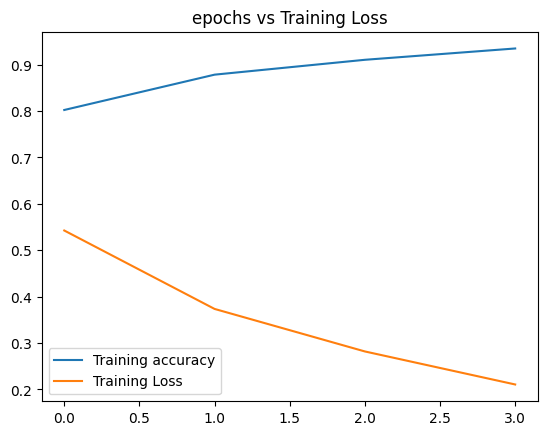

In [32]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

count = range(len(train_accuracy))
plt.plot(count, train_accuracy, label='Training accuracy')
plt.plot(count, train_loss, label='Training Loss')
plt.title('epochs vs Training Loss')
plt.legend()

In [33]:
# model_filename = "model.h5"
# model.save(model_filename)

# Transfer learning

***Load Data***

In [34]:
import zipfile
import pandas as pd


with zipfile.ZipFile("/content/data_transfer.zip", "r") as zip_ref:
    zip_ref.extractall("/content")



data_train = pd.read_csv("/content/data_transfer/2018-Valence-oc-En-train.txt",sep='\t')
data_test = pd.read_csv("/content/data_transfer/2018-Valence-oc-En-dev-test.txt",sep='\t')
data_train.head(3)

,ID,Tweet,Affect Dimension,Intensity Class
0,2017-En-30153,@liamch88 yeah! :) playing well,valence,0: neutral or mixed emotional state can be inf...
1,2017-En-40929,At least I don't have a guy trying to discoura...,valence,0: neutral or mixed emotional state can be inf...
2,2017-En-22012,UPLIFT: If you're still discouraged it means y...,valence,0: neutral or mixed emotional state can be inf...


In [35]:
data_train['Intensity Class'] = [x.split(':')[0] for x in data_train['Intensity Class']]
data_test['Intensity Class'] = [x.split(':')[0] for x in data_test['Intensity Class']]

In [36]:
print(data_train.info())
print("---------------------------")
print("Data Traning shape :" , data_train.shape)
print("Data Test shape :" , data_test.shape)
print("Classes in the data training",data_train['Intensity Class'].value_counts())
print("Classes in the test data",data_test['Intensity Class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181 entries, 0 to 1180
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                1181 non-null   object
 1   Tweet             1181 non-null   object
 2   Affect Dimension  1181 non-null   object
 3   Intensity Class   1181 non-null   object
dtypes: object(4)
memory usage: 37.0+ KB
None
---------------------------
Data Traning shape : (1181, 4)
Data Test shape : (449, 4)
Classes in the data training Intensity Class
0     341
-2    249
1     167
-3    129
3     125
2      92
-1     78
Name: count, dtype: int64
Classes in the test data Intensity Class
0     105
-2     95
-3     69
1      58
3      53
2      35
-1     34
Name: count, dtype: int64


***Data cleaning***

In [37]:
data_train = data_train.drop(['Affect Dimension', 'ID'], axis=1)
data_test = data_test.drop(['Affect Dimension', 'ID'], axis=1)

In [38]:
data_train['Tweet'] =   data_train['Tweet'].apply(clean_text_fun)
data_test['Tweet']  =   data_test['Tweet'].apply(clean_text_fun)

***Data Augmentation***

In [39]:
import random

               The data seems to have only 1181 rows which is might be an issue that why we decided to go with data augmentation techniques like:
                      Synonym Replacement, Random Insertion....

In [40]:
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms

def synonym_replacement(sentence, n=2):
    words = nltk.word_tokenize(sentence)
    augmented_sentences = []
    for _ in range(n):
        for i in range(len(words)):
            synonyms = get_synonyms(words[i])
            if synonyms:
                synonym = random.choice(synonyms)
                words[i] = synonym
                augmented_sentences.append(' '.join(words))
    return augmented_sentences

def random_insertion(sentence, n=2):
    words = nltk.word_tokenize(sentence)
    augmented_sentences = []
    word_list = list(wordnet.words())
    for _ in range(n):
        new_sentence = words.copy()
        for _ in range(3):
            new_word = random.choice(word_list)
            random_index = random.randint(0, len(new_sentence) - 1)
            new_sentence.insert(random_index, new_word)
        augmented_sentences.append(' '.join(new_sentence))
    return augmented_sentences


def random_deletion(sentence, p=0.2):
    words = nltk.word_tokenize(sentence)
    augmented_sentences = []
    for word in words:
        if random.random() > p:
            augmented_sentences.append(' '.join(words))
        else:
            words.remove(word)
            augmented_sentences.append(' '.join(words))
    return augmented_sentences



In [41]:
# This function is to apply the data augmentation functions we create above to each class separately to keep the classes

def augment_data_by_class(data, class_column, text_column):
    augmented_data = pd.DataFrame(columns=[class_column, text_column])
    for class_label in data[class_column].unique():
        class_data = data[data[class_column] == class_label]
        synonym_replacements = class_data[text_column].apply(synonym_replacement)
        random_insertions = class_data[text_column].apply(random_insertion)
        random_deletions = class_data[text_column].apply(random_deletion)

        augmented_data = pd.concat([augmented_data, pd.DataFrame({class_column: [class_label]*len(synonym_replacements.explode()),
                                                                 text_column: synonym_replacements.explode()})])
        augmented_data = pd.concat([augmented_data, pd.DataFrame({class_column: [class_label]*len(random_insertions.explode()),
                                                                 text_column: random_insertions.explode()})])
        augmented_data = pd.concat([augmented_data, pd.DataFrame({class_column: [class_label]*len(random_deletions.explode()),
                                                                 text_column: random_deletions.explode()})])

    return augmented_data

augmented_data = augment_data_by_class(data_train, 'Intensity Class', 'Tweet')
augmented_data

,Intensity Class,Tweet
0,0,yeah play well
0,0,yeah encounter well
0,0,yeah encounter well
0,0,yea encounter well
0,0,yea run_into well
...,...,...
1171,-1,di dat nigga fume right
1171,-1,di dat nigga fume right
1171,-1,di dat nigga fume right
1171,-1,di dat nigga fume right


**tokenize_pad_sequences & Word2Vec model**

In [42]:
augmented_data.isnull().sum()

Intensity Class     0
Tweet              15
dtype: int64

In [43]:
augmented_data.dropna(inplace = True, axis=0)
augmented_data.isnull().sum(), augmented_data.shape

(Intensity Class    0
 Tweet              0
 dtype: int64,
 (25096, 2))

In [44]:
X_7_test, tokenizer = tokenize_pad_sequences(data_test['Tweet'])
X_7, tokenizer = tokenize_pad_sequences(augmented_data['Tweet'])

In [45]:
word2vec_model = Word2Vec(sentences=X_7.tolist(), vector_size=100, window=5, min_count=1, workers=4)

In [46]:
def word2vec_embedding(text_data, model, tokenizer):
    embeddings = []
    for sentence in text_data:
        embedding = []
        for word_index in sentence:
            word = tokenizer.index_word.get(word_index, '')
            if word and word in model.wv:
                embedding.append(model.wv[word])
        embeddings.append(embedding)
    return embeddings

X_w2v_7 = word2vec_embedding(X_7, word2vec_model, tokenizer)


In [47]:
y = augmented_data['Intensity Class']
X_train, X_test, y_train, y_test = train_test_split(X_7, y, test_size=0.2, random_state=42)
num_classes = 7
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test , num_classes=num_classes)

In [48]:
X_train.shape, y_train_encoded.shape

((20076, 100), (20076, 7))

***Apply transfer learning***

In [49]:
from keras.models import load_model



pretrained_model = load_model('/content/best_model.h5')
pretrained_model.pop()
pretrained_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          10051300  
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           19264     
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 64)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 32)                10368     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
Total params: 10080932 (38.46 MB)
Trainable params: 1008

In [50]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Precision, Recall
from keras.optimizers import Adam

pretrained_model.add(Dense(7,activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


pretrained_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',Precision(), Recall()])
history = pretrained_model.fit(X_train, y_train_encoded, epochs=30,
                               validation_data=(X_test, y_test_encoded),
                               callbacks=[early_stopping, model_checkpoint])



Epoch 1/30
628/628 [==============================] - 189s 295ms/step - loss: 1.1071 - accuracy: 0.6031 - precision: 0.2669 - recall: 0.8445 - val_loss: 0.2614 - val_accuracy: 0.9357 - val_precision: 0.3191 - val_recall: 0.9918
Epoch 2/30
628/628 [==============================] - 182s 290ms/step - loss: 0.2066 - accuracy: 0.9507 - precision: 0.3173 - recall: 0.9960 - val_loss: 0.0772 - val_accuracy: 0.9799 - val_precision: 0.3254 - val_recall: 0.9988
Epoch 3/30
628/628 [==============================] - 183s 292ms/step - loss: 0.0909 - accuracy: 0.9795 - precision: 0.3238 - recall: 0.9992 - val_loss: 0.0599 - val_accuracy: 0.9835 - val_precision: 0.3474 - val_recall: 0.9990
Epoch 4/30
628/628 [==============================] - 182s 290ms/step - loss: 0.0552 - accuracy: 0.9878 - precision: 0.3264 - recall: 0.9996 - val_loss: 0.0568 - val_accuracy: 0.9847 - val_precision: 0.3868 - val_recall: 0.9990
Epoch 5/30
628/628 [==============================] - 183s 290ms/step - loss: 0.0477 - a

In [51]:
model_filename = "model2.h5"
pretrained_model.save(model_filename)

***test it***

In [52]:
y_test_T_encoded = to_categorical(data_test['Intensity Class'], num_classes=7)

y_test_T_encoded.shape , X_7_test.shape

((449, 7), (449, 100))

In [53]:
# Evaluate the model
test_loss = pretrained_model.evaluate(X_test, y_test_encoded)
print("Test Loss:", test_loss)


157/157 [==============================] - 2s 12ms/step - loss: 0.0341 - accuracy: 0.9934 - precision: 0.4052 - recall: 0.9988
Test Loss: [0.034079208970069885, 0.9934263229370117, 0.40523719787597656, 0.9988048076629639]


In [ ]:
sentiment_classes = [-3, -2, -1,0,1,2,3]
y_pred = pretrained_model.predict(X_test)
cm = confusion_matrix(np.argmax(np.array(y_test_encoded),axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)



# Evaluate

In [55]:
from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr
def evaluate_model(predictions, labels):
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    pearson_corr, _ = pearsonr(predicted_classes, true_classes)

    weighted_kappa = cohen_kappa_score(predicted_classes, true_classes, weights='quadratic')

    return pearson_corr, weighted_kappa


    weighted_kappa = cohen_kappa_score(predictions, labels, weights='quadratic')

    return pearson_corr, weighted_kappa

predictions = pretrained_model.predict(X_test)

pearson_corr, weighted_kappa = evaluate_model(predictions, y_test_encoded)

print("Pearson correlation coefficient:", pearson_corr)
print("Weighted quadratic kappa:", weighted_kappa)


157/157 [==============================] - 2s 13ms/step
Pearson correlation coefficient: 0.9952112864899227
Weighted quadratic kappa: 0.9952112223878216
